# Tutorial 5: 3D generation model
We extended STAGE on mouse olfactory bulb Slide-seq data with 3D structure. We selected eight consecutive sections from the second tissue. We aligned these sections, selected a part of beads, filtered out low-quality genes, and merged them into one AnnData object. The generated sections were generated between real sections. We trained five of the eight real sections to simultaneously performed recovery and generation experimentals.

The original Slide-seq data can be downloaded from  Gene Expression Omnibus (GEO) accession [GSE169021](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE169021). We provided the SCANPY object, barcodes of selected beads, and sections alignment information at [Google Drive](https://drive.google.com/drive/folders/17nvB2UMm62xOYZPJ6ZcmrOZJIa66e3cK).

## Data preprocessing

In [1]:
import warnings
warnings.filterwarnings("ignore")
import STAGE
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import scipy.sparse as sp

In [2]:
input_dir = 'Data/T5/MOB_3D.h5ad'
adata = sc.read_h5ad(input_dir)

In [3]:
adata

AnnData object with n_obs × n_vars = 131828 × 15176
    obs: 'xcoord', 'ycoord', 'section'
    var: 'n_cells'
    obsm: 'coord', 'spatial'

In [4]:
# Coordinate (xcoord, ycoord) and section (section)
# Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Running model

In [5]:
adata_stage, adata_simu, adata_all = STAGE.STAGE(
    adata,
    save_path='./T5_3d_model',
    data_type='Slide-seq',
    experiment='3d_model',
    coord_sf=6000,
    sec_name='section',
    select_section=[1, 3, 5, 6, 8],
    gap=0.05,
    train_epoch=1000,
    seed=1234, 
    batch_size=8192,
    learning_rate=1e-3,
    w_recon=0.1,
    w_w=0.1,
    w_l1=0.1,
    relu=True,
    device='cuda:0'
)

Epochs: 100%|████| 1000/1000 [9:03:56<00:00, 32.64s/it, latent_loss: 0.00567, recon_loss: 0.14473, total_loss: 0.02014]


In [6]:
adata_stage

AnnData object with n_obs × n_vars = 131828 × 5000
    obs: 'xcoord', 'ycoord', 'section'
    obsm: 'coord'

In [7]:
adata_simu

AnnData object with n_obs × n_vars = 123930 × 5000
    obs: 'xcoord', 'ycoord', 'zcoord'
    obsm: 'coord'

In [8]:
adata_all

AnnData object with n_obs × n_vars = 255758 × 5000
    obs: 'xcoord', 'ycoord'
    obsm: 'coord'

## 2D visualization of recovered data

In [9]:
# Select marker genes
show_gene=["Pcp4","Lrp1b"]

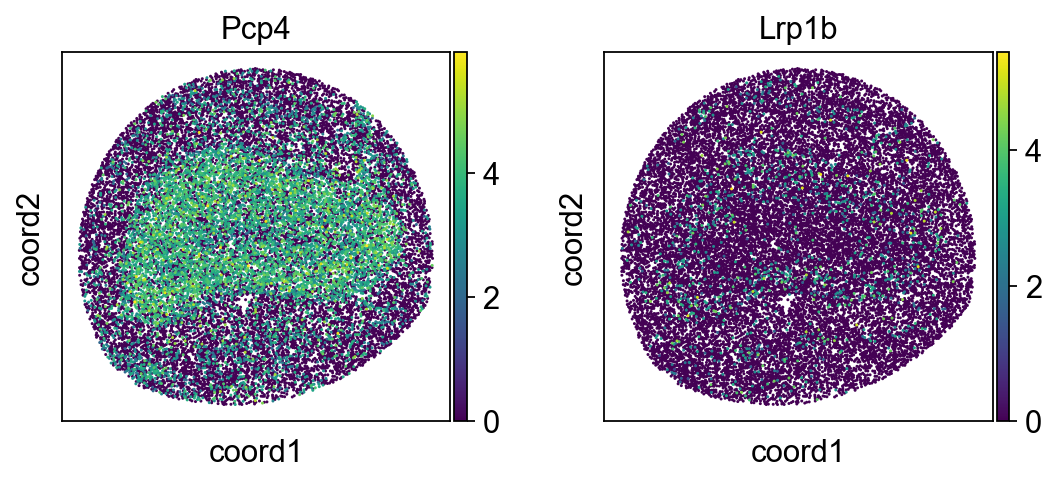

In [11]:
# original data of section 4
sc.set_figure_params(dpi=80, figsize=(3, 3))
sc.pl.embedding(adata[adata.obs['section']==4], basis="coord", color=show_gene)

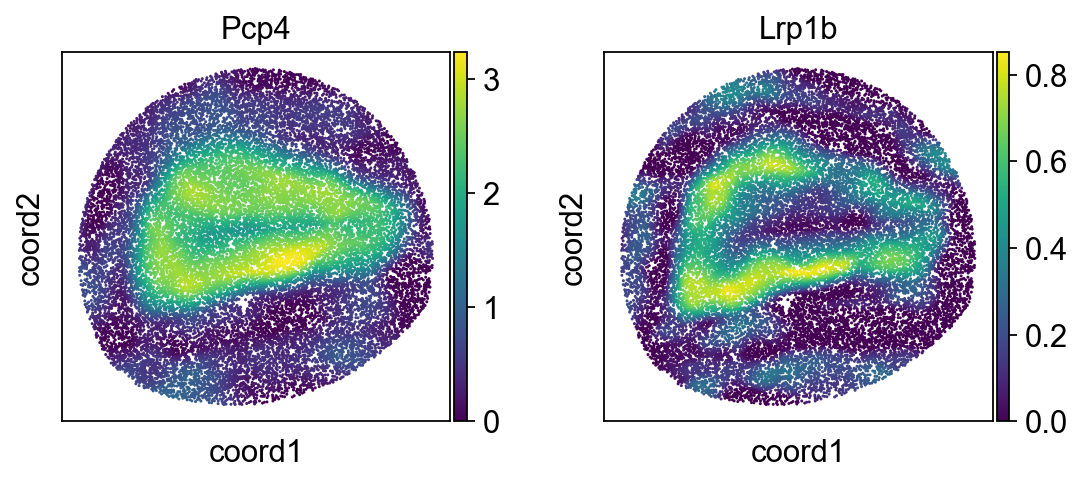

In [12]:
# recovered data of section 4
sc.pl.embedding(adata_stage[adata_stage.obs['section']==4], basis="coord", color=show_gene)

## 3D visualization of all data

In [13]:
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(0.9, 0.24705882, N)
vals[:, 1] = np.linspace(0.9, 0, N)
vals[:, 2] = np.linspace(0.9, 0.49019608, N)
newcmp = ListedColormap(vals)

In [14]:
# Select marker genes: Nrxn3, Pcp4, Nrsn1, Malat1, Lrp1b, Doc2g
plot_gene="Pcp4"

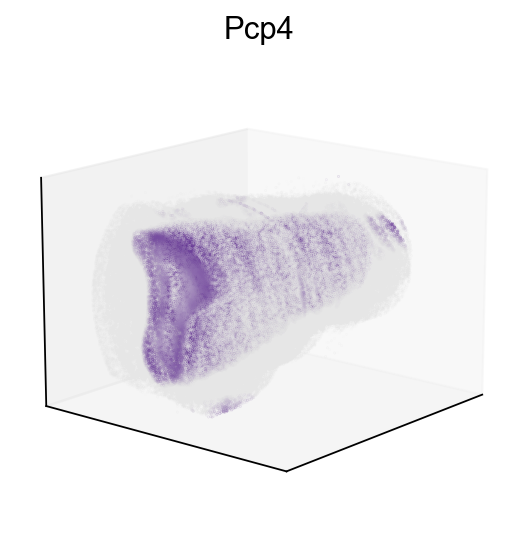

In [15]:
plot_expr=np.array(sp.coo_matrix(adata_all[:,plot_gene].X).todense())

fig = plt.figure(figsize=(4, 4))
ax1 = plt.axes(projection='3d')

ax1.scatter3D(adata_all.obsm["coord"][:,2], adata_all.obsm["coord"][:,1], -adata_all.obsm["coord"][:,0], 
              c=1*(plot_expr/max(plot_expr))**1, \
              alpha=1*(plot_expr/max(plot_expr))**1, \
              cmap=newcmp,
              s=0.05*((plot_expr/max(plot_expr))**1*0.9+0.1), \
              vmin=0.1*max(plot_expr))

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])

ax1.set_ylim(2101.1-828.815/1, 4998.1+828.815/1)
ax1.set_zlim(-5691.2, -1136.57)

plt.title(plot_gene)

ax1.elev = 15
ax1.azim = 40